In [1]:
import sys
 
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '../')
import myTA
import datetime as dt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import linregress
import matplotlib.pyplot as plt
import warnings

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [60]:
# Pivot finding
def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0
    
    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.Low[l]>df1.Low[i]):
            pividlow=0
        if(df1.High[l]<df1.High[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0

def pointpos(x):
    if x['pivot']==1:
        return x['Low']-1e-3
    elif x['pivot']==2:
        return x['High']+1e-3
    else:
        return np.nan

# Patterns finding
def fitTrianglesForCandle(df, candleid, backcandles=20):
    maxim = np.array([])
    minim = np.array([])
    xxmin = np.array([])
    xxmax = np.array([])

    for i in range(candleid-backcandles, candleid+1):
        if df.iloc[i].pivot == 1:
            minim = np.append(minim, df.iloc[i].Low)
            xxmin = np.append(xxmin, i)
        if df.iloc[i].pivot == 2:
            maxim = np.append(maxim, df.iloc[i].High)
            xxmax = np.append(xxmax, i)

    slmin, intercmin, rmin, pmin, semin = linregress(xxmin, minim)
    slmax, intercmax, rmax, pmax, semax = linregress(xxmax, maxim)
    return slmin, intercmin, rmin, pmin, semin, slmax, intercmax, rmax, pmax, semax, xxmin, minim, xxmax, maxim

def searchForPatterns(df, backcandles=20, minPts=3):
    warnings.filterwarnings("ignore")
    validCandles = pd.DataFrame(columns=['candleid','rmax','rmin','slmin','slmax','xxmax_size','xxmin_size'])
    prev = 0
    for candleid in range(1, len(df)):
        idx = df.iloc[candleid-backcandles:candleid+1]['pivot']==1
        idx = idx.index[idx]
        minim = df.loc[idx, 'Low'].values
        xxmin = idx.values

        idx = df.iloc[candleid-backcandles:candleid+1]['pivot']==2
        idx = idx.index[idx]
        maxim = df.loc[idx, 'High'].values
        xxmax = idx.values

        if (xxmax.size < minPts and xxmin.size <minPts) or xxmax.size==0 or xxmin.size==0:
            continue

        slmin, intercmin, rmin, pmin, semin = linregress(xxmin, minim)
        slmax, intercmax, rmax, pmax, semax = linregress(xxmax, maxim)
        
        if candleid - prev > 1:
            validCandles = pd.concat([validCandles, pd.DataFrame({'candleid':[candleid],
            'rmax':[np.abs(rmax)],
            'rmin':[np.abs(rmin)],
            'slmin':[slmin],
            'slmax':[slmax],
            'xxmax_size':[xxmax.size],
            'xxmin_size':[xxmin.size]
            })])
        prev = candleid

    validCandles = validCandles.dropna().reset_index().drop(columns='index')
    validCandles['pattern_type'] = ''
    for i in range(len(validCandles)):
        validCandles.loc[i,'pattern_type'] = categorizePattern(validCandles.iloc[i])
    warnings.filterwarnings("default")
    return validCandles

def visualizeValidCandle(df, candleid, backcandles=20, visualize=False):
    slmin, intercmin, rmin, pmin, semin, slmax, intercmax, rmax, pmax, semax, xxmin, minim, xxmax, maxim = fitTrianglesForCandle(df, candleid, backcandles)
    dfpl = df[np.max([candleid-backcandles-30, 0]):candleid+backcandles+30]

    xxmin = np.append(xxmin, np.max([xxmin[-1], xxmax[-1]]))
    xxmax = np.append(xxmax, np.max([xxmin[-1], xxmax[-1]]))


    triangle = pd.DataFrame(columns=['x', 'ymin', 'ymax', 'min', 'max'])
    x = candleid - backcandles
    ymin = slmin*x + intercmin
    ymax = slmax*x + intercmax

    while ymin < ymax and x < candleid+10:
        ymin = slmin*x + intercmin
        ymax = slmax*x + intercmax
        triangle = pd.concat([triangle, pd.DataFrame({'x':[x], 'ymin':[ymin], 'ymax':[ymax], 'min':[df.iloc[x].Low], 'max':[df.iloc[x].High]})])
        x += 1
    triangle.set_index('x', inplace=True)

    if visualize:
        fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                        open=dfpl['Open'],
                        high=dfpl['High'],
                        low=dfpl['Low'],
                        close=dfpl['Close'])])
        fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                        marker=dict(size=4, color="MediumPurple"),
                        name="pivot")
        fig.add_scatter(x=[candleid], y=[df.iloc[candleid].Close-2e-3], mode="markers",
                        marker=dict(size=6, color="Blue"),
                        name="pattern till")
        fig.add_trace(go.Scatter(x=xxmin, y=slmin*xxmin + intercmin, mode='lines', name='min slope'))
        fig.add_trace(go.Scatter(x=xxmax, y=slmax*xxmax + intercmax, mode='lines', name='max slope'))
        fig.update_layout(xaxis_rangeslider_visible=False)
        fig.show()

        # triangle.plot(figsize=(25,7))
        # plt.vlines(candleid, triangle['ymin'].min(), triangle['ymin'][candleid], linestyles='--', colors='orange')
        # plt.show()
    return triangle

# Opportunity Class
class Opportunity:
    def __init__(self, df, triangle, candleid, backcandles) -> None:
        self.df = df
        self.triangle = triangle
        self.candleid = candleid
        self.backcandles = backcandles

        priorDataTimeWindow = 30
        priorData = self.df.iloc[np.max([candleid-priorDataTimeWindow, 0]):candleid]
        self.priorData = priorData
        self.priorTrend = {
            'min': priorData['Low'].min(),
            'max': priorData['High'].max(),
            'volatility%': (priorData['High'].max()-priorData['Low'].min())/priorData.iloc[-1].Close*100,
            'change': priorData.iloc[-1].Close-priorData.iloc[0].Open
        }
        self.momentum = 'bullish' if self.priorTrend['change'] > 0 else 'bearish'

        self.enterIndex, self.breakOutSignal = Opportunity.whenToEnterAndSignal(self.triangle, self.candleid, self.backcandles)
        self.enterIndex += 1 # one day delay, this is in times (days, h...) after candleid

        self.enterPrice = self.df.loc[self.candleid+self.enterIndex, 'Open'] # assume we buy at open

        self.kind = 'long' # 'long' 'short'  # for now I'' only do Long as we don't determin optimal kind of trade so far
        returnsTimeFrame = 50
        self.returns = self.df.loc[self.candleid+self.enterIndex:self.candleid+self.enterIndex+returnsTimeFrame]['Close'] - self.enterPrice
        self.returns = np.concatenate([self.returns, [0 for _ in range(51-len(self.returns))]])


        # TODO
        # determine optimal kind of trade
    def determineContinuation(self):
        self.enterIndex, self.breakOutSignal = Opportunity.whenToEnterAndSignal(self.triangle, self.candleid, self.backcandles)

    def plotEverything(self):
        dfpl = self.df[self.candleid-self.backcandles-30:self.candleid+self.backcandles+30]
        fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                        open=dfpl['Open'],
                        high=dfpl['High'],
                        low=dfpl['Low'],
                        close=dfpl['Close'])])
        fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                        marker=dict(size=4, color="MediumPurple"),
                        name="pivot")
        fig.add_scatter(x=[self.candleid], y=[df.iloc[self.candleid].Close-2e-3], mode="markers",
                        marker=dict(size=6, color="Blue"),
                        name="pattern till")

        fig.add_trace(go.Scatter(x=self.triangle.index.values, y=self.triangle['ymin'].values, mode='lines', name='min slope'))
        fig.add_trace(go.Scatter(x=self.triangle.index.values, y=self.triangle['ymax'].values, mode='lines', name='max slope'))
        fig.update_layout(xaxis_rangeslider_visible=False)
        fig.show()

        self.triangle.plot(figsize=(25,7))
        try: # sometimes triangle can end before candleid
            plt.vlines(self.candleid, self.triangle['ymin'].min(), self.triangle['ymin'][self.candleid], linestyles='--', colors='orange')
        except:
            pass
        plt.title(f"momentum: {self.momentum} breakout signal: {self.breakOutSignal}")
        plt.show()

        self.returns.plot(figsize=(25,7))
        plt.title(f"momentum: {self.momentum}           breakout signal: {self.breakOutSignal}")
        plt.show()

    def whenToEnterAndSignal(triangle, candleid, backcandles):
        val = 0
        for i in range(backcandles, len(triangle)):
            if triangle.iloc[i]['max'] > triangle.iloc[i]['ymax']:
                val += triangle.iloc[i]['max'] - triangle.iloc[i]['ymax']
            if triangle.iloc[i]['min'] < triangle.iloc[i]['ymin']:
                val -= triangle.iloc[i]['ymin'] - triangle.iloc[i]['min']
            if val/((triangle.loc[candleid, 'min']+triangle.loc[candleid, 'max'])/2) < -0.1:
                return i-backcandles , 'bearish'
            if val/((triangle.loc[candleid, 'min']+triangle.loc[candleid, 'max'])/2) > 0.1:
                return i-backcandles , 'bullish'
        return 0, 'bullish' if val > 0 else 'bearish'

# automated analysis
def showPatterns(df, backcandles):
    df['pivot'] = df.apply(lambda x: pivotid(df, x.name,3,3), axis=1)
    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    print("data analyzed")

    warnings.filterwarnings("ignore")
    validCandles = searchForPatterns(df, backcandles=backcandles)
    validCandles = np.array(validCandles)[np.diff(np.concatenate([[0], validCandles]))>1]
    print(f"{len(validCandles)} valid candles found, printing plots...")
    for validCandle in validCandles:
        print(f"------------------------ validCandle: {validCandle} ------------------------")
        triangle = visualizeValidCandle(df, validCandle, backcandles=backcandles)
        opportunity = Opportunity(df, triangle, validCandle, backcandles)
        # opportunity.plotEverything()
    warnings.filterwarnings("default")

def categorizePattern(row): # to be validated
    # Triangles
    if row.slmax < 0.1 and row.slmin > 0.1:
        return 'Symmetrical Triangle'
    elif row.slmax < 0.1 and row.slmin < 0.1 and row.slmin - row.slmax > 0.05:
        return 'Falling Wedge'
    elif row.slmax < 0.1 and row.slmax > -0.1 and row.slmin > 0.1:
        return 'Ascending Triangle'
    elif row.slmin < 0.1 and row.slmin > -0.1 and row.slmax < 0:
        return 'Descending Triangle'
    elif row.slmin < 0.1 and row.slmin > -0.1 and row.slmax < 0:
        return 'Rising Wedge'
    # Rectangles
    elif row.slmax < 0.1 and row.slmax > -0.1 and row.slmin < 0.1 and row.slmin > -0.1:
        return 'Rectangle'
    # Flag
    elif row.slmax > 0.1 and row.slmax < -0.1 and np.abs(row.slmin - row.slmax) < 0.1:
        return 'Flag'

def queryPatterns(validCandles, pattern_name, rlevel):
    return validCandles[(validCandles['pattern_type']==pattern_name) & (validCandles['rmax'] > rlevel) & (validCandles['rmin'] > rlevel)]

In [78]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import linregress
import matplotlib.pyplot as plt
import warnings

# Pivot finding
def pivotid(df1, l, n1, n2): #n1 n2 before and after candle l
    if l-n1 < 0 or l+n2 >= len(df1):
        return 0
    
    pividlow=1
    pividhigh=1
    for i in range(l-n1, l+n2+1):
        if(df1.Low[l]>df1.Low[i]):
            pividlow=0
        if(df1.High[l]<df1.High[i]):
            pividhigh=0
    if pividlow and pividhigh:
        return 3
    elif pividlow:
        return 1
    elif pividhigh:
        return 2
    else:
        return 0

def pointpos(x):
    if x['pivot']==1:
        return x['Low']-1e-3
    elif x['pivot']==2:
        return x['High']+1e-3
    else:
        return np.nan

# Patterns finding
def fitTrianglesForCandle(df, candleid, backcandles=20):
    idx = df.iloc[candleid-backcandles:candleid+1]['pivot']==1
    idx = idx.index[idx]
    minim = df.loc[idx, 'Low'].values
    xxmin = idx.values

    idx = df.iloc[candleid-backcandles:candleid+1]['pivot']==2
    idx = idx.index[idx]
    maxim = df.loc[idx, 'High'].values
    xxmax = idx.values

    slmin, intercmin, rmin, pmin, semin = linregress(xxmin, minim)
    slmax, intercmax, rmax, pmax, semax = linregress(xxmax, maxim)
    return slmin, intercmin, rmin, pmin, semin, slmax, intercmax, rmax, pmax, semax, xxmin, minim, xxmax, maxim

def searchForValidCandles(df, backcandles=20, minNoPoints=3, fitThreshold=0.9):
    validCandles = []
    for candleid in range(1, len(df)):
        maxim = np.array([])
        minim = np.array([])
        xxmin = np.array([])
        xxmax = np.array([])
        for i in range(candleid-backcandles, candleid+1):
            if df.iloc[i].pivot == 1:
                minim = np.append(minim, df.iloc[i].Low)
                xxmin = np.append(xxmin, i)
            if df.iloc[i].pivot == 2:
                maxim = np.append(maxim, df.iloc[i].High)
                xxmax = np.append(xxmax, i)

        if (xxmax.size <minNoPoints and xxmin.size <minNoPoints) or xxmax.size==0 or xxmin.size==0:
            continue

        slmin, intercmin, rmin, pmin, semin = linregress(xxmin, minim)
        slmax, intercmax, rmax, pmax, semax = linregress(xxmax, maxim)
            
        if abs(rmax)>=fitThreshold and abs(rmin)>=fitThreshold and slmin>=0.0001 and slmax<=-0.0001:
            validCandles.append(candleid)
    return validCandles

def searchForPatterns(df, backcandles=20, minPts=3):
    warnings.filterwarnings("ignore")
    validCandles = pd.DataFrame(columns=['candleid','rmax','rmin','slmin','slmax','xxmax_size','xxmin_size'])
    prev = 0
    for candleid in range(1, len(df)):
        idx = df.iloc[candleid-backcandles:candleid+1]['pivot']==1
        idx = idx.index[idx]
        minim = df.loc[idx, 'Low'].values
        xxmin = idx.values

        idx = df.iloc[candleid-backcandles:candleid+1]['pivot']==2
        idx = idx.index[idx]
        maxim = df.loc[idx, 'High'].values
        xxmax = idx.values

        if (xxmax.size < minPts and xxmin.size <minPts) or xxmax.size==0 or xxmin.size==0:
            continue

        slmin, intercmin, rmin, pmin, semin = linregress(xxmin, minim)
        slmax, intercmax, rmax, pmax, semax = linregress(xxmax, maxim)
        
        if candleid - prev > 1:
            validCandles = pd.concat([validCandles, pd.DataFrame({'candleid':[candleid],
            'rmax':[np.abs(rmax)],
            'rmin':[np.abs(rmin)],
            'slmin':[slmin],
            'slmax':[slmax],
            'xxmax_size':[xxmax.size],
            'xxmin_size':[xxmin.size]
            })])
        prev = candleid

    validCandles = validCandles.dropna().reset_index().drop(columns='index')
    validCandles['pattern_type'] = ''
    for i in range(len(validCandles)):
        validCandles.loc[i,'pattern_type'] = categorizePattern(validCandles.iloc[i])
    warnings.filterwarnings("default")
    return validCandles

def visualizeValidCandle(df, candleid, backcandles=20, visualize=False):
    slmin, intercmin, rmin, pmin, semin, slmax, intercmax, rmax, pmax, semax, xxmin, minim, xxmax, maxim = fitTrianglesForCandle(df, candleid, backcandles)
    dfpl = df[candleid-backcandles-30:candleid+backcandles+30]

    xxmin = np.append(xxmin, np.max([xxmin[-1], xxmax[-1]]))
    xxmax = np.append(xxmax, np.max([xxmin[-1], xxmax[-1]]))


    triangle = pd.DataFrame(columns=['x', 'ymin', 'ymax', 'min', 'max'])
    x = candleid - backcandles
    ymin = slmin*x + intercmin
    ymax = slmax*x + intercmax

    while ymin < ymax:
        ymin = slmin*x + intercmin
        ymax = slmax*x + intercmax
        triangle = pd.concat([triangle, pd.DataFrame({'x':[x], 'ymin':[ymin], 'ymax':[ymax], 'min':[df.iloc[x].Low], 'max':[df.iloc[x].High]})])
        x += 1
        if x > len(df)-1:
            break
    triangle.set_index('x', inplace=True)

    if visualize:
        fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                        open=dfpl['Open'],
                        high=dfpl['High'],
                        low=dfpl['Low'],
                        close=dfpl['Close'])])
        fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                        marker=dict(size=4, color="MediumPurple"),
                        name="pivot")
        fig.add_scatter(x=[candleid], y=[df.iloc[candleid].Close-2e-3], mode="markers",
                        marker=dict(size=6, color="Blue"),
                        name="pattern till")
        fig.add_trace(go.Scatter(x=xxmin, y=slmin*xxmin + intercmin, mode='lines', name='min slope'))
        fig.add_trace(go.Scatter(x=xxmax, y=slmax*xxmax + intercmax, mode='lines', name='max slope'))
        fig.update_layout(xaxis_rangeslider_visible=False)
        fig.show()

        triangle.plot(figsize=(25,7))
        plt.vlines(candleid, triangle['ymin'].min(), triangle['ymin'][candleid], linestyles='--', colors='orange')
        plt.show()
    return triangle

# Opportunity Class
class Opportunity:
    def __init__(self, df, triangle, candleid, backcandles) -> None:
        self.df = df
        self.triangle = triangle
        self.candleid = candleid
        self.backcandles = backcandles

        priorDataTimeWindow = 30
        priorData = self.df.iloc[np.max([candleid-priorDataTimeWindow, 0]):candleid]
        self.priorData = priorData
        self.priorTrend = {
            'min': priorData['Low'].min(),
            'max': priorData['High'].max(),
            'volatility%': (priorData['High'].max()-priorData['Low'].min())/priorData.iloc[-1].Close*100,
            'change': priorData.iloc[-1].Close-priorData.iloc[0].Open,
            'change%': (priorData.iloc[-1].Close-priorData.iloc[0].Open)/priorData.iloc[-1].Close*100
        }
        self.momentum = 'bullish' if self.priorTrend['change'] > 0 else 'bearish'

        self.enterIndex, self.breakOutSignal = Opportunity.whenToEnterAndSignal(self.triangle, self.candleid, self.backcandles)
        self.enterIndex += 1 # one day delay, this is in times (days, h...) after candleid

        self.enterPrice = self.df.loc[self.candleid+self.enterIndex, 'Open'] # assume we buy at open

        self.kind = 'long' # 'long' 'short'  # for now I'' only do Long as we don't determin optimal kind of trade so far
        returnsTimeFrame = 50
        self.returns = self.df.loc[self.candleid+self.enterIndex:self.candleid+self.enterIndex+returnsTimeFrame]['Close'] - self.enterPrice
        self.returns = np.concatenate([self.returns, [0 for _ in range(returnsTimeFrame+1-len(self.returns))]])
        self.returnsPercent = (self.df.loc[self.candleid+self.enterIndex:self.candleid+self.enterIndex+returnsTimeFrame]['Close'] - self.enterPrice)/self.enterPrice*100
        self.returnsPercent = np.concatenate([self.returnsPercent, [0 for _ in range(returnsTimeFrame+1-len(self.returnsPercent))]])

        # TODO
        # determine optimal kind of trade
    # def determineContinuation(self):
    #     self.enterIndex, self.breakOutSignal = Opportunity.whenToEnterAndSignal(self.triangle, self.candleid, self.backcandles)

    def plotEverything(self):
        dfpl = self.df[np.max([self.candleid-self.backcandles-30, 0]):self.candleid+self.backcandles+30]
        fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                        open=dfpl['Open'],
                        high=dfpl['High'],
                        low=dfpl['Low'],
                        close=dfpl['Close'])])
        fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                        marker=dict(size=4, color="MediumPurple"),
                        name="pivot")
        fig.add_scatter(x=[self.candleid], y=[self.df.iloc[self.candleid].Close-2e-3], mode="markers",
                        marker=dict(size=6, color="Blue"),
                        name="pattern till")

        fig.add_trace(go.Scatter(x=self.triangle.index.values, y=self.triangle['ymin'].values, mode='lines', name='min slope'))
        fig.add_trace(go.Scatter(x=self.triangle.index.values, y=self.triangle['ymax'].values, mode='lines', name='max slope'))
        fig.update_layout(xaxis_rangeslider_visible=False)
        fig.show()

        self.triangle.plot(figsize=(25,7))
        try: # sometimes triangle can end before candleid
            plt.vlines(self.candleid, self.triangle['ymin'].min(), self.triangle['ymin'][self.candleid], linestyles='--', colors='orange')
        except:
            pass
        plt.title(f"momentum: {self.momentum} breakout signal: {self.breakOutSignal}")
        plt.show()

        self.returns.plot(figsize=(25,7))
        plt.title(f"momentum: {self.momentum}           breakout signal: {self.breakOutSignal}")
        plt.show()

    def whenToEnterAndSignal(triangle, candleid, backcandles):
        val = 0
        for i in range(backcandles, len(triangle)):
            if triangle.iloc[i]['max'] > triangle.iloc[i]['ymax']:
                val += triangle.iloc[i]['max'] - triangle.iloc[i]['ymax']
            if triangle.iloc[i]['min'] < triangle.iloc[i]['ymin']:
                val -= triangle.iloc[i]['ymin'] - triangle.iloc[i]['min']
            if val/((triangle.loc[candleid, 'min']+triangle.loc[candleid, 'max'])/2) < -0.1:
                return i-backcandles , 'bearish'
            if val/((triangle.loc[candleid, 'min']+triangle.loc[candleid, 'max'])/2) > 0.1:
                return i-backcandles , 'bullish'
        return 0, 'bullish' if val > 0 else 'bearish'

def categorizePattern(row): # to be validated
    # Triangles
    if row.slmax < 0.1 and row.slmin > 0.1:
        return 'Symmetrical Triangle'
    elif row.slmax < 0.1 and row.slmin < 0.1 and row.slmin - row.slmax > 0.05:
        return 'Falling Wedge'
    elif row.slmax < 0.1 and row.slmax > -0.1 and row.slmin > 0.1:
        return 'Ascending Triangle'
    elif row.slmin < 0.1 and row.slmin > -0.1 and row.slmax < 0:
        return 'Descending Triangle'
    elif row.slmin < 0.1 and row.slmin > -0.1 and row.slmax < 0:
        return 'Rising Wedge'
    # Rectangles
    elif row.slmax < 0.1 and row.slmax > -0.1 and row.slmin < 0.1 and row.slmin > -0.1:
        return 'Rectangle'
    # Flag
    elif row.slmax > 0.1 and row.slmax < -0.1 and np.abs(row.slmin - row.slmax) < 0.1:
        return 'Flag'

def queryPatterns(validCandles, pattern_name, rlevel):
    return validCandles[(validCandles['pattern_type']==pattern_name) & (validCandles['rmax'] > rlevel) & (validCandles['rmin'] > rlevel)]

# automated analysis
def showPatterns(df, backcandles, minNoPoints=3, fitThreshold=0.5):
    df['pivot'] = df.apply(lambda x: pivotid(df, x.name,3,3), axis=1)
    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    print("data analyzed")

    warnings.filterwarnings("ignore")
    validCandles = searchForValidCandles(df, backcandles=backcandles, minNoPoints=minNoPoints, fitThreshold=fitThreshold)
    validCandles = np.array(validCandles)[np.diff(np.concatenate([[0], validCandles]))>1]
    print(f"{len(validCandles)} valid candles found, printing plots...")
    for validCandle in validCandles:
        print(f"------------------------ validCandle: {validCandle} ------------------------")
        triangle = visualizeValidCandle(df, validCandle, backcandles=backcandles)
        opportunity = Opportunity(df, triangle, validCandle, backcandles)
        opportunity.plotEverything()
    warnings.filterwarnings("default")

def getPatterns(df, code, backcandles, minNoPoints=3, fitThreshold=0.5):
    patterns = pd.DataFrame(columns=['code','momentum','momentumChange%','breakOutSignal','returnsPercent'])
    df['pivot'] = df.apply(lambda x: pivotid(df, x.name,3,3), axis=1)
    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    print("data analyzed")

    warnings.filterwarnings("ignore")
    validCandles = searchForPatterns(df, backcandles=backcandles, minPts=minNoPoints)
    validCandlesList = validCandles['candleid']
    # validCandles = np.array(validCandles)[np.diff(np.concatenate([[0], validCandles]))>1]
    print(f"{len(validCandles)} valid candles found, printing plots...")
    for validCandle in validCandlesList:
        triangle = visualizeValidCandle(df, validCandle, backcandles=backcandles)
        opportunity = Opportunity(df, triangle, validCandle, backcandles)
        patterns = pd.concat([patterns, pd.DataFrame({'code':[code],'momentum':[opportunity.momentum], 'momentumChange%':[opportunity.priorTrend['change%']], 'breakOutSignal':[opportunity.breakOutSignal],'returnsPercent':[opportunity.returnsPercent]})])
    warnings.filterwarnings("default")
    return pd.merge(left=patterns.reset_index().drop(columns='index').reset_index(), right=validCandles.reset_index()).drop(columns='index')

In [117]:
def getPatterns(df, code, backcandles, minNoPoints=3, fitThreshold=0.5):
    patterns = pd.DataFrame(columns=['code','momentum','momentumChange%','breakOutSignal','returnsPercent'])
    df['pivot'] = df.apply(lambda x: pivotid(df, x.name,3,3), axis=1)
    df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)
    print("data analyzed")

    warnings.filterwarnings("ignore")
    validCandles = searchForPatterns(df, backcandles=backcandles, minPts=minNoPoints)
    validCandlesList = validCandles['candleid']
    # validCandles = np.array(validCandles)[np.diff(np.concatenate([[0], validCandles]))>1]
    print(f"{len(validCandles)} valid candles found, printing plots...")
    for validCandle in validCandlesList:
        triangle = visualizeValidCandle(df, validCandle, backcandles=backcandles)
        opportunity = Opportunity(df, triangle, validCandle, backcandles)
        patterns = pd.concat([patterns, pd.DataFrame({'code':[code],'momentum':[opportunity.momentum], 'momentumChange%':[opportunity.priorTrend['change%']], 'breakOutSignal':[opportunity.breakOutSignal],'returnsPercent':[opportunity.returnsPercent]})])
    warnings.filterwarnings("default")
    return pd.merge(left=patterns.reset_index().drop(columns='index').reset_index(), right=validCandles.reset_index()).drop(columns='index')

In [121]:
code='BTC-USD'
backcandles = 20
df = myTA.downloadAndMakeAnalysis(code, dt.datetime(2022,1,1), dt.datetime.now(),'1d').reset_index()
a,b,c = getPatterns(df, code, backcandles)

data analyzed
12 valid candles found, printing plots...


c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequen

In [120]:
c

,code,momentum,momentumChange%,breakOutSignal,returnsPercent,candleid,rmax,rmin,slmin,slmax,xxmax_size,xxmin_size,pattern_type
0,BTC-USD,bearish,-27.643465,bullish,"[0.5678657033771874, 12.332100145170106, 12.17...",26,0.913174,1.0,-472.322266,-411.309532,3,2,None
1,BTC-USD,bearish,-12.054629,bullish,"[0.9474990723804912, -1.308359417277369, -1.71...",73,1.0,0.962252,185.712203,-373.129464,2,3,Symmetrical Triangle
2,BTC-USD,bearish,-23.896041,bearish,"[-15.895940287692007, -16.945383516294076, -15...",154,1.0,0.625256,46.692129,58.854492,2,3,None
3,BTC-USD,bearish,-43.969284,bullish,"[-0.1701812364231585, -0.7926364937144665, -2....",189,0.997975,1.0,85.0861,41.470289,3,2,None
4,BTC-USD,bearish,-21.308271,bullish,"[-0.8825845737747526, -5.758833564908454, -3.4...",241,1.0,0.99604,-167.334597,-302.78924,2,3,Falling Wedge
5,BTC-USD,bearish,-23.048816,bearish,"[0.2068050767229116, 10.84093981136947, 12.392...",250,1.0,0.996957,-122.903537,-315.565918,2,3,Falling Wedge
6,BTC-USD,bearish,-9.202352,bullish,"[0.2800911742928438, -2.394621815953798, -2.04...",256,0.665244,1.0,-106.257595,75.425045,3,2,None
7,BTC-USD,bearish,-4.135863,bullish,"[1.5151576414348338, 2.6149480227744406, 1.713...",287,0.776333,1.0,-15.564974,-25.720685,3,2,Falling Wedge
8,BTC-USD,bullish,5.669106,bearish,"[-14.360524502533387, -5.160712529040785, -8.1...",302,0.91388,1.0,56.393555,83.247281,3,2,None
9,BTC-USD,bullish,4.663454,bearish,"[-14.360524502533387, -5.160712529040785, -8.1...",309,0.98946,1.0,101.174579,100.775134,3,2,None


In [43]:
code='BTC-USD'
backcandles = 20
df = myTA.downloadAndMakeAnalysis(code, dt.datetime(2000,1,1), dt.datetime.now(),'1d').reset_index()
df['pivot'] = df.apply(lambda x: pivotid(df, x.name,3,3), axis=1)
df['pointpos'] = df.apply(lambda row: pointpos(row), axis=1)


dfpl = df
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.add_scatter(x=dfpl.index, y=dfpl['pointpos'], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="pivot")
fig.show()

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [85]:
validCandles = searchForPatterns(df, backcandles=20, minPts=3)

In [86]:
validCandles

,candleid,rmax,rmin,slmin,slmax,xxmax_size,xxmin_size,pattern_type
0,73,0.988833,1.0,2.048998,-4.540806,3,2,Symmetrical Triangle
1,85,1.0,0.423474,-0.424878,-1.774994,2,3,Falling Wedge
2,109,1.0,0.662037,-2.160814,-1.761332,2,3,None
3,119,1.0,0.998882,-9.107914,-3.6135,2,3,None
4,146,1.0,0.915133,0.358426,-7.928375,2,3,Symmetrical Triangle
...,...,...,...,...,...,...,...,...
95,2949,0.776333,1.0,-15.564974,-25.720685,3,2,Falling Wedge
96,2964,0.91388,1.0,56.393555,83.247281,3,2,None
97,2971,0.98946,1.0,101.174579,100.775134,3,2,None
98,2975,1.0,0.516208,-120.141469,65.498884,2,3,None


In [95]:
patterns.reset_index().drop(columns='index')

,code,momentum,momentumChange%,breakOutSignal,returnsPercent
0,BTC-USD,bullish,10.821703,bullish,"[-1.6272798654464227, 0.3023589194094283, -0.2..."
1,BTC-USD,bearish,-5.627591,bearish,"[-2.6233273831762767, -0.6072882027996753, 3.1..."
2,BTC-USD,bearish,-31.435661,bearish,"[-20.452089354974813, -6.275292427641653, -7.0..."
3,BTC-USD,bearish,-55.56515,bearish,"[18.624957108188802, 17.637380163859227, 12.64..."
4,BTC-USD,bearish,-24.759439,bearish,"[-0.24893829013671606, 0.9247688043267819, 7.1..."
...,...,...,...,...,...
95,BTC-USD,bearish,-4.135863,bullish,"[1.5151576414348338, 2.6149480227744406, 1.713..."
96,BTC-USD,bullish,5.669106,bearish,"[-14.360524502533387, -5.160712529040785, -8.1..."
97,BTC-USD,bullish,4.663454,bearish,"[-14.360524502533387, -5.160712529040785, -8.1..."
98,BTC-USD,bearish,-4.881782,bearish,"[-3.122056066980464, -4.4591660765610035, -6.9..."


In [101]:
patterns.reset_index()

,index,code,momentum,momentumChange%,breakOutSignal,returnsPercent
0,0,BTC-USD,bullish,10.821703,bullish,"[-1.6272798654464227, 0.3023589194094283, -0.2..."
1,0,BTC-USD,bearish,-5.627591,bearish,"[-2.6233273831762767, -0.6072882027996753, 3.1..."
2,0,BTC-USD,bearish,-31.435661,bearish,"[-20.452089354974813, -6.275292427641653, -7.0..."
3,0,BTC-USD,bearish,-55.56515,bearish,"[18.624957108188802, 17.637380163859227, 12.64..."
4,0,BTC-USD,bearish,-24.759439,bearish,"[-0.24893829013671606, 0.9247688043267819, 7.1..."
...,...,...,...,...,...,...
95,0,BTC-USD,bearish,-4.135863,bullish,"[1.5151576414348338, 2.6149480227744406, 1.713..."
96,0,BTC-USD,bullish,5.669106,bearish,"[-14.360524502533387, -5.160712529040785, -8.1..."
97,0,BTC-USD,bullish,4.663454,bearish,"[-14.360524502533387, -5.160712529040785, -8.1..."
98,0,BTC-USD,bearish,-4.881782,bearish,"[-3.122056066980464, -4.4591660765610035, -6.9..."


<AxesSubplot:>

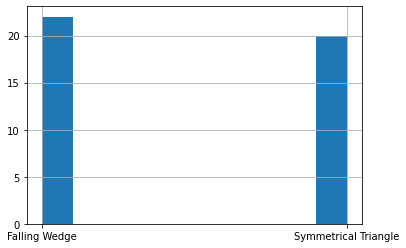

In [67]:
validCandles['pattern_type'].hist()

In [66]:
currdf

,candleid,rmax,rmin,slmin,slmax,xxmax_size,xxmin_size,pattern_type
3,146,1.0,0.966927,1.752105,-7.928375,2,4,Symmetrical Triangle
4,157,0.620813,0.915133,0.358426,-1.487776,4,3,Symmetrical Triangle
20,471,0.942225,0.891497,2.829952,-1.65008,4,3,Symmetrical Triangle
25,664,0.818657,1.0,3.835358,-3.587381,4,2,Symmetrical Triangle
26,682,0.928034,0.975416,1.938213,-1.59508,4,3,Symmetrical Triangle
55,1472,0.647824,0.802405,9.627613,-22.21712,4,3,Symmetrical Triangle
56,1567,1.0,0.908935,20.243496,-61.606738,2,4,Symmetrical Triangle
61,1650,0.612326,0.897497,6.936376,-14.662564,3,4,Symmetrical Triangle
78,2024,0.834033,0.934768,109.918156,-82.203823,4,3,Symmetrical Triangle
83,2103,1.0,0.546979,15.416873,-41.342318,2,4,Symmetrical Triangle


c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexes\base.py:6982: FutureWarning:

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



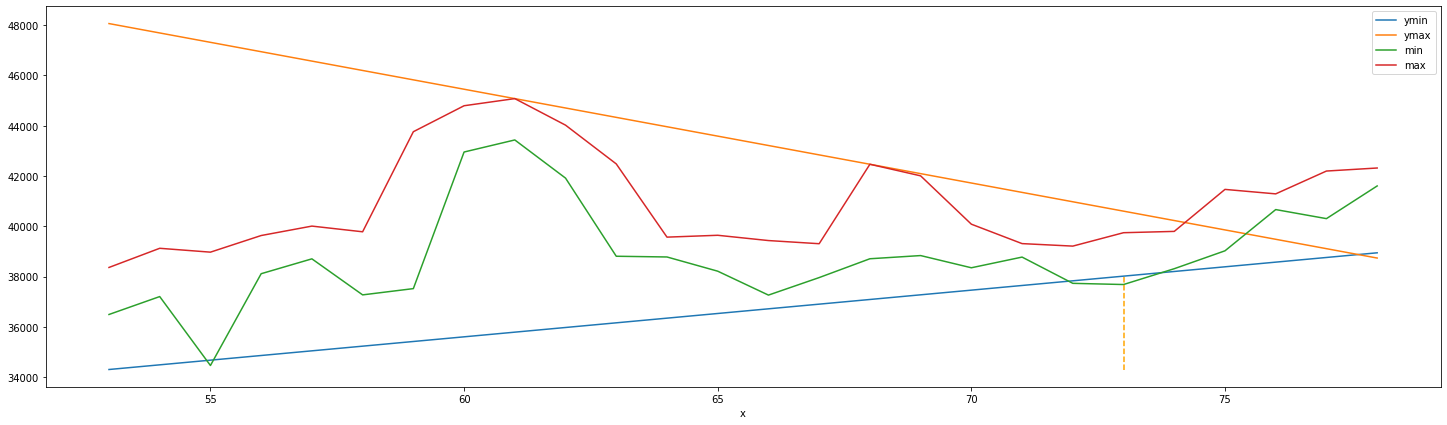

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_mstats_common.py:175: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_mstats_common.py:189: RuntimeWarning:

invalid value encountered in sqrt

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_stats_mstats_common.py:192: RuntimeWarning:

invalid value encountered in double_scalars

c:\Users\QbaSo\AppData\Local\Programs\Python\Python39\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



TypeError: no numeric data to plot

In [122]:
currdf = queryPatterns(validCandles, 'Symmetrical Triangle', 0.5)
for i in range(len(currdf)):
    triangle = visualizeValidCandle(df, currdf.iloc[i].candleid, backcandles=20, visualize=True)